### Base settings

In [2]:
%load_ext autoreload
%autoreload 2

# %env CUDA_VISIBLE_DEVICES=1

import os
import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from einops import rearrange, reduce, repeat
from IPython.display import display

import video_transformer.data_transform as T
from video_transformer.dataset import DecordInit, load_annotation_data
from video_transformer.transformer import PatchEmbed, TransformerContainer, ClassificationHead

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare kinetics400 dataset

In [3]:
# with open('./data/kinetics/k400_train_metadata.pkl', 'rb') as f:
#     k400_train_metadata = pickle.load(f)
    
with open('./data/kinetics/k400_val_metadata.pkl', 'rb') as f:
    k400_val_metadata = pickle.load(f)

In [4]:
# from torchvision.datasets import Kinetics
from ood_with_vit.datasets.kinetics import VideoOnlyKinetics
from torch.utils.data import DataLoader, Dataset

dataset_root = '~/workspace/dataset/kinetics/k400'
dataset_root = os.path.expanduser(dataset_root)
print(dataset_root)

dataset_mean, dataset_std = (0.45, 0.45, 0.45), (0.225, 0.225, 0.225)
val_transform = T.create_video_transform(
    input_size=224,
    is_training=False,
    interpolation='bicubic',
    mean=dataset_mean,
    std=dataset_std,
)

k400_val_ds = VideoOnlyKinetics(
    root=dataset_root,
    frames_per_clip=16,
    split='val',
    num_workers=8,
    frame_rate=2,
    step_between_clips=1,
    transform=val_transform,
    _precomputed_metadata=k400_val_metadata,
)

k400_val_dl = DataLoader(
    dataset=k400_val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=16,
)

/home/simc/workspace/dataset/kinetics/k400


/usr/local/lib/python3.10/site-packages/torchvision/datasets/video_utils.py:223: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(


In [ ]:
k400_train_ds = VideoOnlyKinetics(
    root=dataset_root,
    frames_per_clip=16,
    split='train',
    frame_rate=2,
    step_between_clips=1,
    transform=val_transform,
    _precomputed_metadata=k400_train_metadata,
)

k400_train_dl = DataLoader(
    dataset=k400_train_ds,
    batch_size=32,
    shuffle=False,
    num_workers=16,
)

In [5]:
video, label = k400_val_ds[0]
print(video.shape, k400_val_ds.classes[label])

/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([16, 3, 224, 224]) abseiling


In [6]:
video_paths = k400_val_ds.metadata['video_paths']
video_pts = k400_val_ds.metadata['video_pts']
video_fps = k400_val_ds.metadata['video_fps']
clips = k400_val_ds.video_clips.clips
print('video paths:', type(video_paths), len(video_paths), video_paths[0])
print('video pts:', type(video_pts), len(video_pts), video_pts[0].shape)
print('video fps:', type(video_fps), len(video_fps), video_fps[0])
print('clips', type(clips), len(clips), clips[0].shape)
print('cumulative sizes:', k400_val_ds.video_clips.cumulative_sizes[-1])

video paths: <class 'list'> 19881 /home/simc/workspace/dataset/kinetics/k400/val/abseiling/0wR5jVB-WPk_000417_000427.mp4
video pts: <class 'list'> 19881 torch.Size([300])
video fps: <class 'list'> 19881 29.97002997002997
clips <class 'list'> 19881 torch.Size([5, 16])
cumulative sizes: 88540


#### Prepare ViViT model

In [5]:
from video_transformer.video_transformer import ViViT

In [6]:
def replace_state_dict(state_dict):
	for old_key in list(state_dict.keys()):
		if old_key.startswith('model'):
			new_key = old_key[6:]
			state_dict[new_key] = state_dict.pop(old_key)
		else:
			new_key = old_key[9:]
			state_dict[new_key] = state_dict.pop(old_key)

In [7]:
def init_from_pretrain_(module, pretrained, init_module):
    if torch.cuda.is_available():
        state_dict = torch.load(pretrained)
    else:
        state_dict = torch.load(pretrained, map_location=torch.device('cpu'))
    if init_module == 'transformer':
        replace_state_dict(state_dict)
    elif init_module == 'cls_head':
        replace_state_dict(state_dict)
    else:
        raise TypeError(f'pretrained weights do not include the {init_module} module')
    msg = module.load_state_dict(state_dict, strict=False)
    return msg

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
num_frames = 8
frame_interval = 32
num_class = 400
arch = 'vivit' # turn to vivit for initializing vivit model

pretrain_pth = './logs/vivit/vivit_model.pth'
num_frames = num_frames * 2
frame_interval = frame_interval // 2
model = ViViT(
    num_frames=num_frames,
    img_size=224,
    patch_size=16,
    embed_dims=768,
    in_channels=3,
    attention_type='fact_encoder',
    return_cls_token=True,
    pretrain_pth=pretrain_pth,
    weights_from='kinetics',
)

cls_head = ClassificationHead(num_classes=num_class, in_channels=768)
# msg_trans = init_from_pretrain_(model, pretrain_pth, init_module='transformer')
msg_cls = init_from_pretrain_(cls_head, pretrain_pth, init_module='cls_head')
model.eval()
cls_head.eval()
model = model.to(device)
cls_head = cls_head.to(device)
print(f'load model finished, the missing key of cls is:{msg_cls[0]}')

_IncompatibleKeys(missing_keys=[], unexpected_keys=['cls_head.weight', 'cls_head.bias'])
load model finished, the missing key of cls is:[]


In [9]:
print(model)

ViViT(
  (patch_embed): PatchEmbed(
    (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
  )
  (transformer_layers): ModuleList(
    (0): TransformerContainer(
      (layers): ModuleList(
        (0): BasicTransformerBlock(
          (attentions): ModuleList(
            (0): MultiheadAttentionWithPreNorm(
              (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): Attention(
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=768, out_features=768, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (proj_drop): Dropout(p=0.0, inplace=False)
              (layer_drop): DropPath()
            )
          )
          (ffns): ModuleList(
            (0): FFNWithPreNorm(
              (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         

In [10]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [11]:
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor
from ood_with_vit.mim.attention_masking import AttentionMaskingHooker
from ood_with_vit.mim.video_spatial_attention_masking import VideoSpatialAttentionMaskingHooker
from ood_with_vit.mim.video_temporal_attention_masking import VideoTemporalAttentionMaskingHooker
from ood_with_vit.visualizer import ViTAttentionRollout

In [20]:
attention_extractor.remove_hooks()
attention_masking_hooker.remove_hooks()

In [12]:
attention_extractor = FeatureExtractor(
    model=model,
    layer_name='attn_drop'
)
attention_extractor.hook()

# add hooks for attention masking
mask_method = 'bottom_ratio'
mask_ratio = 0.1
head_fusion = 'max'
discard_ratio = 0.9

spatial_attention_masking_hooker = VideoSpatialAttentionMaskingHooker(
    config=config,
    model=model,
    attention_extractor=attention_extractor,
    patch_embedding_layer_name='patch_embed.projection',
    mask_method=mask_method,
    mask_ratio=mask_ratio,
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
spatial_attention_masking_hooker.hook()

temporal_attention_masking_hooker = VideoTemporalAttentionMaskingHooker(
    config=config,
    model=model,
    attention_extractor=attention_extractor,
    patch_embedding_layer_name='patch_embed.projection',
    mask_method=mask_method,
    mask_ratio=mask_ratio,
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
# temporal_attention_masking_hooker.hook()

visualizer = ViTAttentionRollout(
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)

In [13]:
x, y = k400_val_ds[0]
x = x.to(device)
x = torch.stack([x, x])
print(x.shape)
logits = attention_extractor(x)
print('logits:', logits.shape)
features = attention_extractor.features

/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([2, 16, 3, 224, 224])
logits: torch.Size([2, 768])


In [14]:
print('input:', x.shape)
print('n_attn_maps:', len(features))
for i, attn_map in enumerate(features):
    print(i, 'attn_map:', features[i].shape)

input: torch.Size([2, 16, 3, 224, 224])
n_attn_maps: 16
0 attn_map: torch.Size([16, 12, 197, 197])
1 attn_map: torch.Size([16, 12, 197, 197])
2 attn_map: torch.Size([16, 12, 197, 197])
3 attn_map: torch.Size([16, 12, 197, 197])
4 attn_map: torch.Size([16, 12, 197, 197])
5 attn_map: torch.Size([16, 12, 197, 197])
6 attn_map: torch.Size([16, 12, 197, 197])
7 attn_map: torch.Size([16, 12, 197, 197])
8 attn_map: torch.Size([16, 12, 197, 197])
9 attn_map: torch.Size([16, 12, 197, 197])
10 attn_map: torch.Size([16, 12, 197, 197])
11 attn_map: torch.Size([16, 12, 197, 197])
12 attn_map: torch.Size([2, 12, 9, 9])
13 attn_map: torch.Size([2, 12, 9, 9])
14 attn_map: torch.Size([2, 12, 9, 9])
15 attn_map: torch.Size([2, 12, 9, 9])


In [15]:
import cv2

def apply_mask_on_img(img, mask):
    img_h, img_w, _ = img.shape
    mask = cv2.resize(mask, (img_h, img_w), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    masked_img = img * (1 - mask)
    return masked_img

In [16]:
def visualize_attention_map(
    original_img, 
    rollout_attention_map,
    visualizer,
):
    mask = rollout_attention_map

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    visualized_img = visualizer.get_visualized_masks(original_img, mask)
    visualized_img = visualized_img[:, :, ::-1]
    plt.imshow(visualized_img)

    plt.subplot(1, 3, 3)
    plt.imshow(mask)
    cax = fig.add_axes([
        ax.get_position().x1 + 0.01,
        ax.get_position().y0 + ax.get_position().height * 0.2, 
        0.02,
        ax.get_position().height * 0.6
    ])
    plt.colorbar(cax=cax)

    plt.show()

def visualize_attention_masking(
    original_img,
    attention_mask,
):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    visualized_img = apply_mask_on_img(original_img, attention_mask)
    visualized_img = visualized_img.astype(np.int32)
    plt.imshow(visualized_img)

    plt.subplot(1, 3, 3)
    plt.imshow(attention_mask)
    cax = fig.add_axes([
        ax.get_position().x1 + 0.01,
        ax.get_position().y0 + ax.get_position().height * 0.2, 
        0.02,
        ax.get_position().height * 0.6
    ])
    plt.colorbar(cax=cax)

    plt.show()

In [17]:
transforms_without_normalize = T.transforms_eval_without_normalize(
    img_size=224,
    interpolation='bicubic',
)

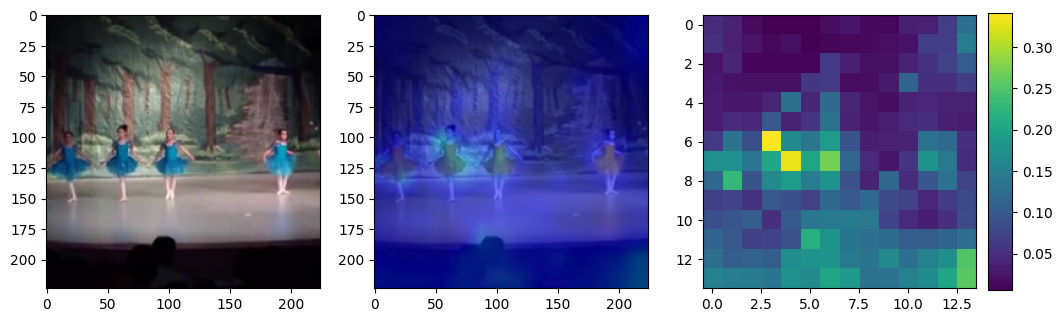

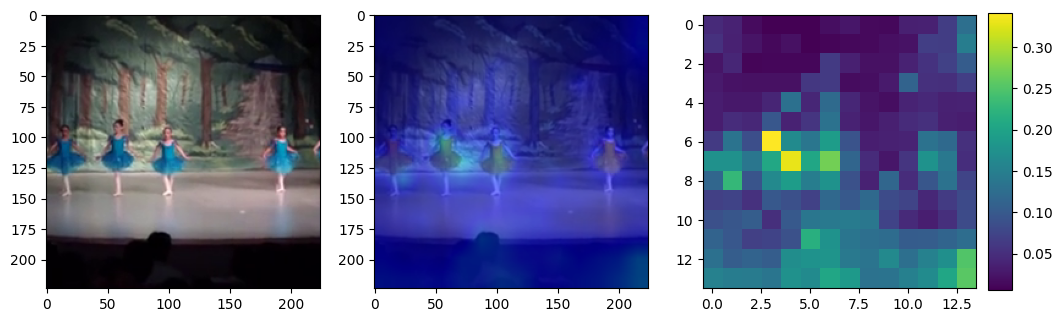

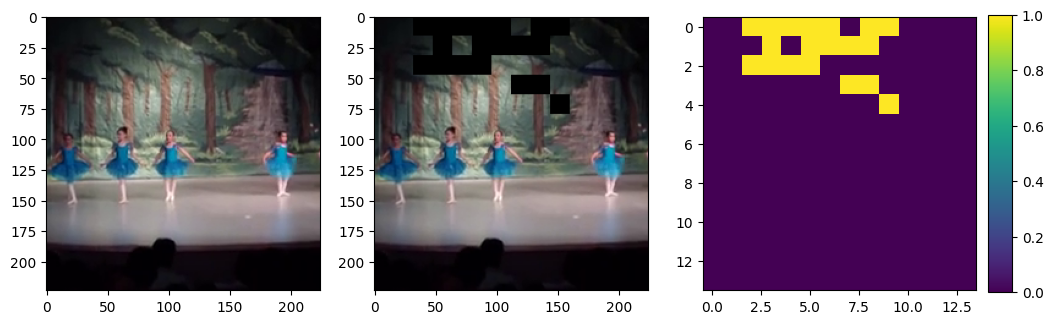

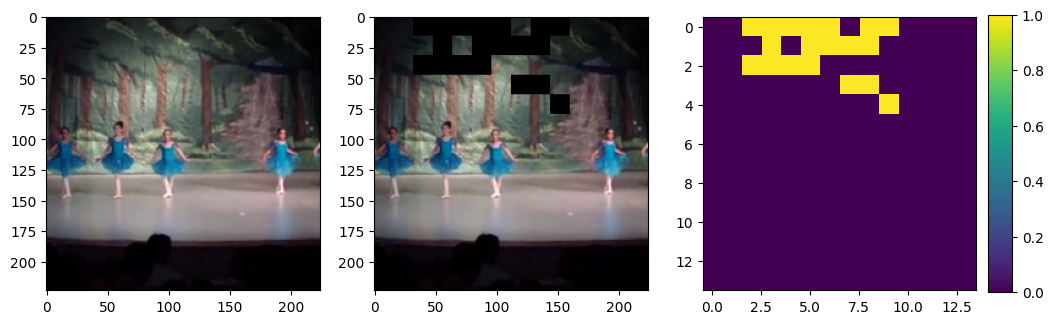

before: torch.Size([16, 14, 14])
after: torch.Size([2, 1, 8, 14, 14])
label: dancing_ballet
masks: (16, 14, 14)
spatial attn maps: 12 torch.Size([16, 12, 197, 197])
rollout spatial attn maps: (16, 14, 14)
before: dancing_ballet 19.511335372924805 after: dancing_ballet 19.173620223999023


In [22]:
clip_idx, img_idx = 19000, 0
ori_video, _, _, _ = k400_val_ds.video_clips.get_clip(clip_idx)
ori_video = transforms_without_normalize(ori_video)
original_image1 = ori_video[img_idx * 2].permute(1, 2, 0).numpy()
original_image2 = ori_video[img_idx * 2 + 1].permute(1, 2, 0).numpy()

video, label = k400_val_ds[clip_idx]
video = torch.stack([video, video])
# video = video.unsqueeze(0)
video = video.to(device)

spatial_attention_masking_hooker.switch_status('normal')
attention_extractor.hook()
pre_logits = attention_extractor(video)
ori_logits = cls_head(pre_logits)
spatial_attn_maps = attention_extractor.features[:12]
attention_extractor.remove_hooks()
rollout_spatial_attn_maps = visualizer.spatial_rollout(spatial_attn_maps)
ori_max_logit, ori_pred = ori_logits.max(axis=1)

visualize_attention_map(
    original_img=original_image1,
    rollout_attention_map=rollout_spatial_attn_maps[img_idx],
    visualizer=visualizer,
)
visualize_attention_map(
    original_img=original_image2,
    rollout_attention_map=rollout_spatial_attn_maps[img_idx],
    visualizer=visualizer,
)

masks = spatial_attention_masking_hooker.generate_masks(video)

visualize_attention_masking(
    original_img=original_image1,
    attention_mask=masks[img_idx]
)
visualize_attention_masking(
    original_img=original_image2,
    attention_mask=masks[img_idx]
)

spatial_attention_masking_hooker.switch_status('masking')
mask_pre_logits = model(video)
mask_logits = cls_head(mask_pre_logits)
mask_max_logit, mask_pred = mask_logits.max(axis=1)

# temporal_attn_maps = attention_extractor.features[12:]
# print('temporal attn maps:', len(temporal_attn_maps), temporal_attn_maps[0].shape)
# rollout_temporal_attn_maps = visualizer.temporal_rollout(temporal_attn_maps)

print('label:', k400_val_ds.classes[label])
print('masks:', masks.shape)
print('spatial attn maps:', len(spatial_attn_maps), spatial_attn_maps[0].shape)
print('rollout spatial attn maps:', rollout_spatial_attn_maps.shape)
# print('temporal attn maps:', len(temporal_attn_maps), temporal_attn_maps[0].shape)
# print('rollout spatial attn maps:', rollout_temporal_attn_maps.shape)
ori_pred = k400_val_ds.classes[ori_pred[0].item()]
mask_pred = k400_val_ds.classes[mask_pred[0].item()]
ori_max_logit = ori_max_logit[0].item()
mask_max_logit = mask_max_logit[0].item()
print('before:', ori_pred, ori_max_logit, 'after:', mask_pred, mask_max_logit)

### Compute validation accuracy

In [10]:
model.eval()
criterion = nn.CrossEntropyLoss()
total_test_loss, n_correct, n_total = 0, 0, 0

with torch.no_grad():
    start = time.time()
    for batch_idx, (x, y) in enumerate(tqdm(k400_val_dl)):
        x, y = x.to(device), y.to(device)
        pre_logits = model(x)
        logits = cls_head(pre_logits)
        loss = criterion(logits, y)
        # print(pre_logits.shape)
        # print(outputs.shape)
            
        total_test_loss += loss.item()
        _, predicted = logits.max(1)
        n_total += y.size(0)
        n_correct += predicted.eq(y).sum().item()

    avg_test_loss = total_test_loss / (batch_idx + 1)
    test_accuracy = 100. * n_correct / n_total
    print(f'Test Loss: {avg_test_loss:.3f} | Test Acc: {test_accuracy:.3f}% ({n_correct}/{n_total})')

100%|██████████| 2767/2767 [48:20<00:00,  1.05s/it]

Test Loss: 1.106 | Test Acc: 74.141% (65644/88540)


### Test sample video

In [12]:
from IPython.display import display, HTML

video_path = './YABnJL_bDzw.mp4'
html_str = '''
<video controls width=\"480\" height=\"480\" src=\"{}\">animation</video>
'''.format(video_path)
display(HTML(html_str))

In [13]:
# Prepare data preprocess
mean, std = (0.45, 0.45, 0.45), (0.225, 0.225, 0.225)
data_transform = T.Compose([
        T.Resize(scale_range=(-1, 256)),
        T.ThreeCrop(size=224),
        T.ToTensor(),
        T.Normalize(mean, std)
        ])
temporal_sample = T.TemporalRandomCrop(num_frames*frame_interval)

# Sampling video frames
video_decoder = DecordInit()
v_reader = video_decoder(video_path)
total_frames = len(v_reader)
start_frame_ind, end_frame_ind = temporal_sample(total_frames)
print(total_frames, start_frame_ind, end_frame_ind)
if end_frame_ind-start_frame_ind < num_frames:
    raise ValueError(f'the total frames of the video {video_path} is less than {num_frames}')
frame_indice = np.linspace(0, end_frame_ind-start_frame_ind-1, num_frames, dtype=int)
video = v_reader.get_batch(frame_indice).asnumpy()
del v_reader

print('original:', video.shape)
video = torch.from_numpy(video).permute(0,3,1,2) # Video transform: T C H W
data_transform.randomize_parameters()
video = data_transform(video)
video = video.to(device)
print('transformed:', video.shape)

302 32 288
original: (16, 256, 454, 3)
transformed: torch.Size([3, 16, 3, 224, 224])


In [15]:
# Predict class label
with torch.no_grad():
    pre_logits = model(video)
    print('pre logits:', pre_logits.shape)
    output = cls_head(pre_logits)
    print('output:', output.shape)
    output = output.view(3, 400).mean(0)
    cls_pred = output.argmax().item()
    
print(f'the shape of ouptut: {output.shape}, \
    and the prediction is: {kinetics400_val_ds.classes[cls_pred]}')

pre logits: torch.Size([3, 768])
output: torch.Size([3, 400])
the shape of ouptut: torch.Size([400]),     and the prediction is: laughing


# Cache embeddings

In [6]:
import json

cache_dir = Path('./data')
cache_dir.mkdir(parents=True, exist_ok=True)

### HMDB51

In [23]:
with open('./data/hmdb51/hmdb51_test_metadata.pkl', 'rb') as f:
    hmdb51_test_metadata = pickle.load(f)

In [24]:
from glob import glob
from ood_with_vit.datasets.hmdb51 import VideoOnlyHMDB51
from torch.utils.data import DataLoader, Dataset
from IPython.core.debugger import set_trace

dataset_root = '~/workspace/dataset/hmdb51'
dataset_root = os.path.expanduser(dataset_root)
annotation_path = '~/workspace/dataset/testTrainMulti_7030_splits'
annotation_path = os.path.expanduser(annotation_path)

dataset_mean, dataset_std = (0.45, 0.45, 0.45), (0.225, 0.225, 0.225)
val_transform = T.create_video_transform(
    input_size=224,
    is_training=False,
    interpolation='bicubic',
    mean=dataset_mean,
    std=dataset_std,
)

hmdb51_val_ds = VideoOnlyHMDB51(
    root=dataset_root,
    annotation_path=annotation_path,
    frames_per_clip=16,
    step_between_clips=1,
    frame_rate=2,
    fold=1,
    train=False,
    transform=val_transform,
    num_workers=8,
    output_format='TCHW',
    _precomputed_metadata=hmdb51_test_metadata,
)
hmdb51_val_ds.video_clips.output_format = 'TCHW'

hmdb51_val_dl = DataLoader(
    dataset=hmdb51_val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=8,
)

In [34]:
n_correct, n_total = 0, 0
id, cache_rate = 0, 100
logs = []
hmdb51_root = cache_dir / 'hmdb51'

model.eval()
with torch.no_grad():
    start = time.time()
    for batch_idx, (x, y) in enumerate(tqdm(hmdb51_val_dl)):
        if batch_idx % cache_rate == 0:
            with open(hmdb51_root / f'hmdb51_val_embeddings.jsonl', 'a+') as f:
                for log in logs:
                    f.write(json.dumps(log) + '\n')
            logs = []

        x, y = x.to(device), y.to(device)
        pre_logits = model(x)
        logits = cls_head(pre_logits)
        _, predicted = logits.max(1)

        for pre_logit, logit, gt, pred in zip(pre_logits, logits, y, predicted):
            pre_logit = pre_logit.detach().cpu().numpy().tolist()
            logit = logit.detach().cpu().numpy().tolist()
            gt_label = hmdb51_val_ds.classes[gt.item()]
            pred_label = kinetics400_val_ds.classes[pred.item()]
            logs.append({
                'id': id, 
                'gt': gt_label, 
                'pred': pred_label, 
                'penultimate': pre_logit,
                'logit': logit,
            })
            id += 1
            
        n_total += y.size(0)
        n_correct += predicted.eq(y).sum().item()

    with open(hmdb51_root / f'hmdb51_val_embeddings.jsonl', 'a+') as f:
        for log in logs:
            f.write(json.dumps(log) + '\n')
    logs = []
            
    test_accuracy = 100. * n_correct / n_total
    print(f'Test Acc: {test_accuracy:.3f}% ({n_correct}/{n_total})')

  0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3

Test Acc: 0.000% (0/594)


### UCF101

In [31]:
with open('./data/ucf101/ucf101_test_metadata.pkl', 'rb') as f:
    hmdb51_test_metadata = pickle.load(f)

In [32]:
from glob import glob
from ood_with_vit.datasets.ucf101 import VideoOnlyUCF101
from torch.utils.data import DataLoader, Dataset

dataset_root = '~/workspace/dataset/ucf101'
dataset_root = os.path.expanduser(dataset_root)
annotation_path = '~/workspace/dataset/ucfTrainTestlist'
annotation_path = os.path.expanduser(annotation_path)

dataset_mean, dataset_std = (0.45, 0.45, 0.45), (0.225, 0.225, 0.225)
val_transform = T.create_video_transform(
    input_size=224,
    is_training=False,
    interpolation='bicubic',
    mean=dataset_mean,
    std=dataset_std,
)

ucf101_val_ds = VideoOnlyUCF101(
    root=dataset_root,
    annotation_path=annotation_path,
    frames_per_clip=16,
    step_between_clips=1,
    frame_rate=2,
    fold=1,
    train=False,
    transform=val_transform,
    num_workers=8,
    output_format='TCHW',
    _precomputed_metadata=hmdb51_test_metadata,
)
ucf101_val_ds.video_clips.output_format = 'TCHW'

ucf101_val_dl = DataLoader(
    dataset=ucf101_val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=8,
)

/usr/local/lib/python3.10/site-packages/torchvision/datasets/video_utils.py:223: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(


In [33]:
n_correct, n_total = 0, 0
id, cache_rate = 0, 100
logs = []
ucf101_root = cache_dir / 'ucf101'

model.eval()
with torch.no_grad():
    start = time.time()
    for batch_idx, (x, y) in enumerate(tqdm(ucf101_val_dl)):
        if batch_idx % cache_rate == 0:
            with open(ucf101_root / f'ucf101_val_embeddings.jsonl', 'a+') as f:
                for log in logs:
                    f.write(json.dumps(log) + '\n')
            logs = []

        x, y = x.to(device), y.to(device)
        pre_logits = model(x)
        logits = cls_head(pre_logits)
        _, predicted = logits.max(1)

        for pre_logit, logit, gt, pred in zip(pre_logits, logits, y, predicted):
            pre_logit = pre_logit.detach().cpu().numpy().tolist()
            logit = logit.detach().cpu().numpy().tolist()
            gt_label = ucf101_val_ds.classes[gt.item()]
            pred_label = kinetics400_val_ds.classes[pred.item()]
            logs.append({
                'id': id, 
                'gt': gt_label, 
                'pred': pred_label, 
                'penultimate': pre_logit,
                'logit': logit,
            })
            id += 1
            
        n_total += y.size(0)
        n_correct += predicted.eq(y).sum().item()

    with open(ucf101_root / f'ucf101_val_embeddings.jsonl', 'a+') as f:
        for log in logs:
            f.write(json.dumps(log) + '\n')
    logs = []
            
    test_accuracy = 100. * n_correct / n_total
    print(f'Test Acc: {test_accuracy:.3f}% ({n_correct}/{n_total})')

  0%|          | 0/582 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python

Test Acc: 0.000% (0/9309)


In [37]:
hmdb_classes = ''
for i, cls in enumerate(hmdb51_val_ds.classes):
    hmdb_classes += '\t' + cls
    if (i + 1) % 10 == 0:
        hmdb_classes += '\n'
print('HMDB51:')
print(hmdb_classes)

ucf_classes = ''
for i, cls in enumerate(ucf101_val_ds.classes):
    ucf_classes += '\t' + cls
    if (i + 1) % 10 == 0:
        ucf_classes += '\n'
print('HMDB51:')
print(ucf_classes)

kinetics_classes = ''
for i, cls in enumerate(kinetics400_val_ds.classes):
    kinetics_classes += '\t' + cls
    if (i + 1) % 10 == 0:
        kinetics_classes += '\n'
print('Kinetics400:')
print(kinetics_classes)

HMDB51:
	brush_hair	cartwheel	catch	chew	clap	climb	climb_stairs	dive	draw_sword	dribble
	drink	eat	fall_floor	fencing	flic_flac	golf	handstand	hit	hug	jump
	kick	kick_ball	kiss	laugh	pick	pour	pullup	punch	push	pushup
	ride_bike	ride_horse	run	shake_hands	shoot_ball	shoot_bow	shoot_gun	sit	situp	smile
	smoke	somersault	stand	swing_baseball	sword	sword_exercise	talk	throw	turn	walk
	wave
HMDB51:
	ApplyEyeMakeup	ApplyLipstick	Archery	BabyCrawling	BalanceBeam	BandMarching	BaseballPitch	Basketball	BasketballDunk	BenchPress
	Biking	Billiards	BlowDryHair	BlowingCandles	BodyWeightSquats	Bowling	BoxingPunchingBag	BoxingSpeedBag	BreastStroke	BrushingTeeth
	CleanAndJerk	CliffDiving	CricketBowling	CricketShot	CuttingInKitchen	Diving	Drumming	Fencing	FieldHockeyPenalty	FloorGymnastics
	FrisbeeCatch	FrontCrawl	GolfSwing	Haircut	HammerThrow	Hammering	HandstandPushups	HandstandWalking	HeadMassage	HighJump
	HorseRace	HorseRiding	HulaHoop	IceDancing	JavelinThrow	JugglingBalls	JumpRope	JumpingJack	Kaya